# WEAT 구현

In [3]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [5]:
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [7]:
w2v

In [9]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B#, c_a, c_b

In [11]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [13]:
print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
#print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


# 1. 형태소 분석기를 이용한 품사가 명사인 경우 해당 단어 추출하기

In [17]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [19]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [21]:
print(len(tokenized))

71156


# 2. 추출된 결과로 embedding model 만들기

In [25]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
#model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
#model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
model.most_similar(positive=['영화'])

[('작품', 0.9023582935333252),
 ('다큐멘터리', 0.84445720911026),
 ('드라마', 0.828061580657959),
 ('영화로', 0.8025472164154053),
 ('에마데딘', 0.7947123050689697),
 ('형식', 0.7938510179519653),
 ('코미디', 0.7937326431274414),
 ('감동', 0.7872674465179443),
 ('스토리', 0.7867686748504639),
 ('소재', 0.7866872549057007)]

In [27]:
model.wv.most_similar(positive=['사랑'])

[('아르튬', 0.749350905418396),
 ('첫사랑', 0.7269778251647949),
 ('진심', 0.72662353515625),
 ('애정', 0.7227351665496826),
 ('행복', 0.7119312286376953),
 ('만남', 0.7073003649711609),
 ('셰카르', 0.7048496603965759),
 ('이별', 0.7033333778381348),
 ('고백', 0.6907222270965576),
 ('우정', 0.6864883899688721)]

# 3. TF-IDF로 해당 데이터를 가장 잘 표현하는 단어 셋 만들기

In [31]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [63]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [65]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [66]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [67]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

24574
여권


In [70]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

## 4. Weat Score 구하기

In [71]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [72]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [73]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 멜로로맨스 -1.3515483
공포(호러) 다큐멘터리 1.1625978
기타 멜로로맨스 -1.1769497
다큐멘터리 멜로로맨스 -1.4669414
다큐멘터리 미스터리 -1.296279
다큐멘터리 성인물(에로) -1.2386295
다큐멘터리 스릴러 -1.1654677
멜로로맨스 범죄 1.220182
멜로로맨스 서부극(웨스턴) 1.1498085
멜로로맨스 애니메이션 1.1507095
멜로로맨스 전쟁 1.438506
미스터리 전쟁 1.1633421


<AxesSubplot:>

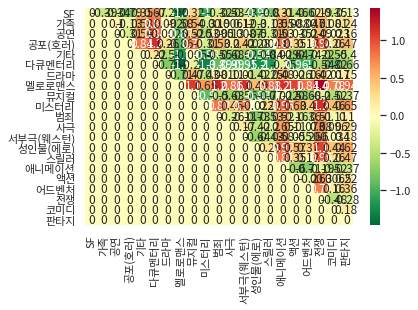

In [74]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

### WEAT Score Heatmap이 출력되었다.

# 회고

## 1. 단어간의 편향성을 알아볼수 있는 WEAT Score에 관련된 노드로, 단어별 벡터의 유사도를 구해 점수를 판별해봤다.
## 2. WEAT Score의 공식이 복잡해 이해하는데 시간이 좀 걸렸다. 
## 3. Score를 살펴보면 SF와 멜로 로멘스가 -1.3수치를 보이는데 두 장르가 상반되는 장르인가? 라는 생각이 들었다. 오히려 공포와 멜로가 더 상반된 수치가 나와야 하는것 아닌가?
## 4. 영화의 장르에 따른 사람들의 주관성의 차이가 나기때문에 이런 점수가 와닿지 않는것 같다. 애초에 비교 테마자체가 너무 모호한 주관성을 가진 주체들이라 그런것 아닌가 싶다.